In [160]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os
import json

In [161]:
# function to load and preprocess quickdraw data
def load_quickdraw_data(dir, category_name, n_samples=1000):
    file = f'full_numpy_bitmap_{category_name}.npy'
    data = np.load(dir + file)
    if n_samples == -1:
        return data
    else:
        indices = np.random.choice(len(data), n_samples, replace=False)
        sampled_data = data[indices]
        return sampled_data

In [162]:
files = os.listdir('../data/')
categories = [file.split('_')[-1].split('.')[0] for file in files]

In [163]:
# Data directory
dir = '../data/'

# Load and preprocess data
all_data = []
labels = []

In [164]:
for category_name in categories:
    category_data = load_quickdraw_data(dir, category_name, 100) # Change this to -1 for all data
    all_data.extend(category_data)
    labels.extend([category_name] * len(category_data))

In [165]:
# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)

print(len(all_data))

34500


In [166]:
# normalize data
x_train = np.array(x_train).astype(np.float32) / 255
x_test = np.array(x_test).astype(np.float32) / 255

# reshape
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [167]:
print(x_train.shape)
print(x_test.shape)

(27600, 784)
(6900, 784)


In [168]:
# Input layer
input_img = Input(shape=(784,))

In [169]:
# Encoder layers
encoded = Dense(256, activation='relu')(input_img)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)

In [170]:
# Decoder layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [171]:
autoencoder = Model(input_img, decoded)

In [172]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [173]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True,
                          validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/100


432/432 [==============================] - 3s 6ms/step - loss: 0.0985 - val_loss: 0.0939
Epoch 2/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0903 - val_loss: 0.0913
Epoch 3/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0867 - val_loss: 0.0902
Epoch 4/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0853 - val_loss: 0.0906
Epoch 5/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0844 - val_loss: 0.0877
Epoch 6/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0837 - val_loss: 0.0874
Epoch 7/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0832 - val_loss: 0.0859
Epoch 8/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0827 - val_loss: 0.0858
Epoch 9/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0824 - val_loss: 0.0847
Epoch 10/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0820 - val_loss: 0.0842
E

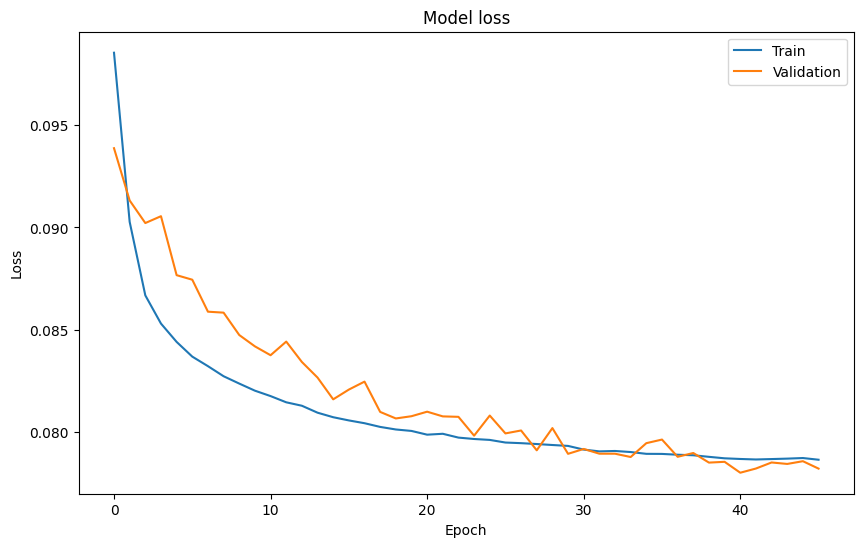

In [174]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [175]:
decoded_imgs = autoencoder.predict(x_test)

216/216 [==============================] - 0s 1ms/step


In [176]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [177]:
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [178]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [y_test[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [  15   17   23   75   83  106  152  176  195  199  217  229  235  242
  257  259  283  286  298  300  329  375  380  381  414  443  460  502
  504  512  528  541  602  616  622  667  690  700  703  761  765  775
  794  795  822  834  862  874  876  884  887  898  908  961  989 1023
 1024 1064 1126 1135 1142 1143 1163 1222 1231 1245 1267 1337 1385 1387
 1396 1399 1435 1463 1466 1478 1481 1546 1550 1579 1605 1623 1689 1703
 1746 1772 1778 1780 1786 1798 1806 1859 1869 1876 1964 1994 2009 2058
 2091 2127 2137 2138 2149 2152 2156 2163 2167 2169 2180 2187 2195 2198
 2278 2297 2306 2328 2342 2358 2360 2371 2419 2432 2440 2466 2497 2503
 2555 2595 2633 2642 2700 2727 2729 2762 2774 2790 2791 2807 2822 2836
 2878 2922 2937 3000 3021 3028 3101 3142 3158 3183 3193 3194 3198 3206
 3225 3236 3330 3331 3339 3340 3360 3379 3394 3415 3517 3519 3532 3544
 3553 3578 3583 3597 3614 3630 3642 3653 3656 3659 3669 3708 3736 3741
 3744 3746 3761 3768 3769 3781 3803 3828 3836 3870 3886 3897

In [179]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

print(len(anomalies))

345


In [180]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [y_test[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [181]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [182]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


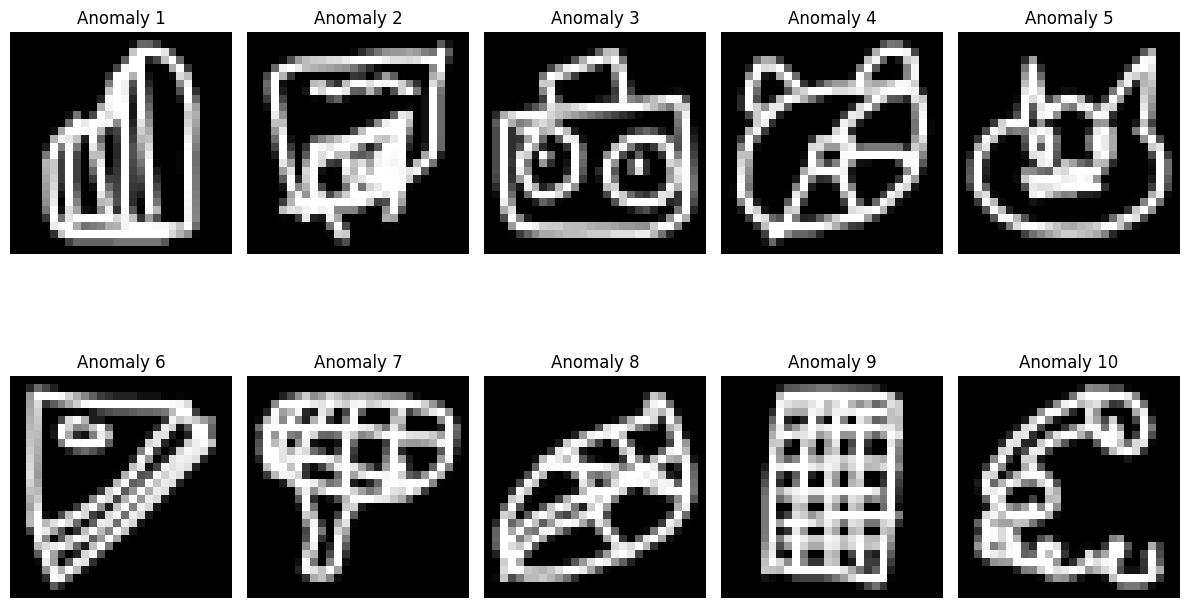

In [183]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


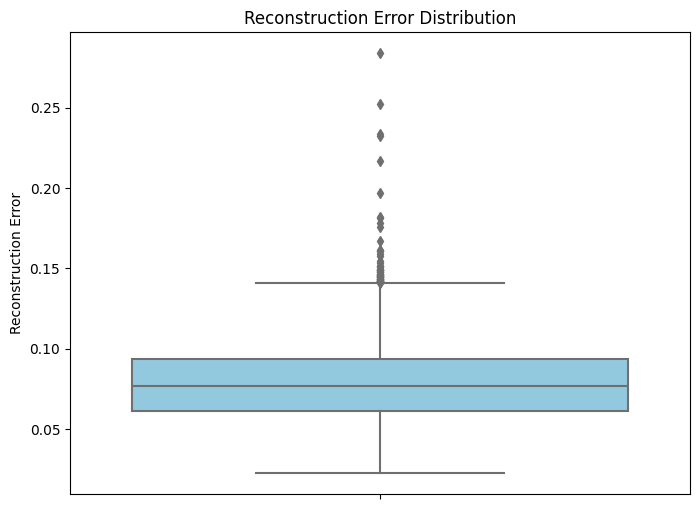

In [184]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

In [185]:
# Convert labels to binary numeric format
y_test_binary = [1 if label in anomaly_labels else 0 for label in y_test]

In [186]:
# Evaluate performance metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_binary, 
                                                                 [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))],
                                                                 average='binary')
accuracy = accuracy_score(y_test_binary, [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))])


In [187]:
# print precision, recall, and f1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 0.11427625041404439
F1 Score: 0.2051129607609988
Accuracy: 0.612463768115942


In [188]:
# Generate classification report
report = classification_report(y_test_binary,
                                     [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))],
                                     target_names=['Normal', 'Anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      1.00      0.74      3881
     Anomaly       1.00      0.11      0.21      3019

    accuracy                           0.61      6900
   macro avg       0.80      0.56      0.47      6900
weighted avg       0.77      0.61      0.51      6900



In [189]:
# Get precision and recall values
precision, recall, _ = precision_recall_curve(y_test_binary, reconstruction_errors)

# Calculate PR-AUC
pr_auc = auc(recall, precision)

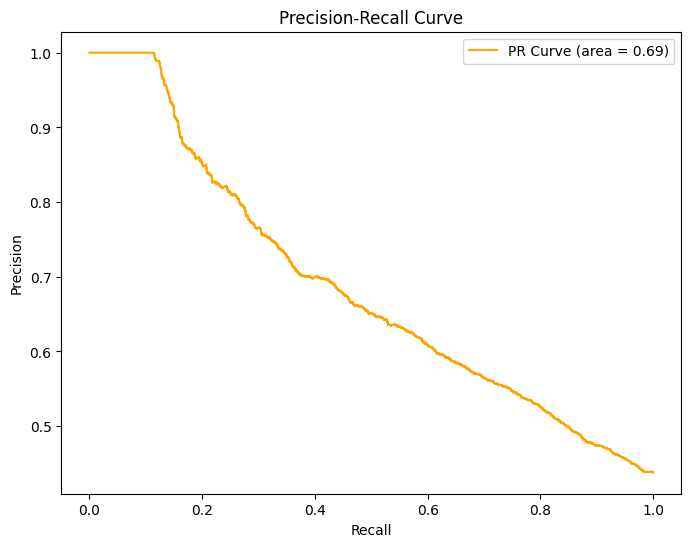

In [190]:
# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [191]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))])

In [192]:
print(conf_matrix)

[[3881    0]
 [2674  345]]


In [193]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 3881
False Positives: 0
False Negatives: 2674
True Positives: 345
